RAS Code Base Tutorial
======================

Introduction
------------

This file serves as a tutorial to using all of the features of the RAS code base. (These hints are using comments to keep the markdown explanations clean.) *Remember*: Most functions have documentation describing arguments, returns, and summaries.

First we import the files we need to use. Any ModuleNotFoundError will require you to install the necessary packages via pip.

In [23]:
from tools.ODE_simulation import * # from "file_name" import * will import every object from the file.
from models.RAS_model import *
#TODO: add a requirements.txt for ease of installing all required packages.

Setting Up a Basic Simulation
-----------------------------

To setup an instance of an ODE_Simulation using four inputs: a model function (in scipy form), a KRAS_Variant instance for WT parameters, a KRAS_Variant instance for Mutant parameters, and a dictionary of other state parameters.

In [2]:
state_parameters = {'GAP':6e-11,'GTP':180e-6,'GDP':18e-6,'GEF':(2e-10)}
sim = ODE_Simulation(RAS_model, WT, G12C, state_parameters) # Class instance will put these arguments into the __init__ function in the class.

Lets run a simple ODE system integration until a given time [s]. An end time and y0 (initial values) iterable must be given.

In [3]:
Total_RAS = 4e-7 #TODO: integrate this into a functin get_y0 so that fract_mut and other ivs can be a state param.
fract_mut = 0.25
WT_iv = Total_RAS*(1-fract_mut)
Mut_iv = Total_RAS*(fract_mut)

y0 = [WT_iv, 0, 0, 4e-7, 0, Mut_iv, 0, 0, 0]
t_end = 1e4
Results = sim.integrate_model(t_end, y0)

The results are saved into a Results object (defined in tools.ODE_Simulation). Raw t and y data can be viewed as well as hard coded expressions. Lets plot a simple comparison from this data.

Text(0, 0.5, 'RAS-GTP-Effector [M]')

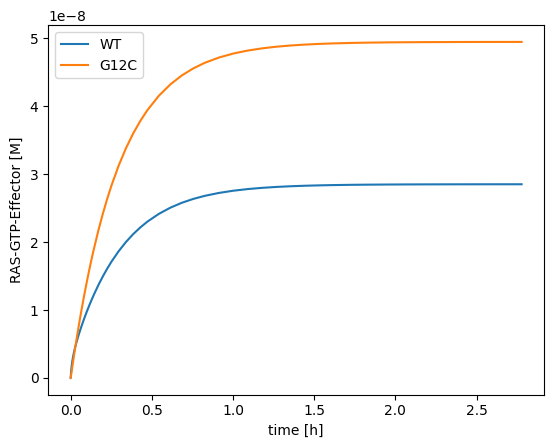

In [4]:
plt.plot(Results.t/3600, Results.y[4,:], label="WT")
plt.plot(Results.t/3600, Results.y[8,:], label=G12C.name)
plt.legend()
plt.xlabel("time [h]")
plt.ylabel("RAS-GTP-Effector [M]")

Perhaps we want to compare the steady state percent of Effector bound to RAS WT or RAS Mutant. We will instead run till steady state, and plot a bar chart using the built in methods of ODE_Simulation and Results. We will make two new simulations with two different mutations.

Text(0.5, 0, 'Mutant type (with 25% mutant)')

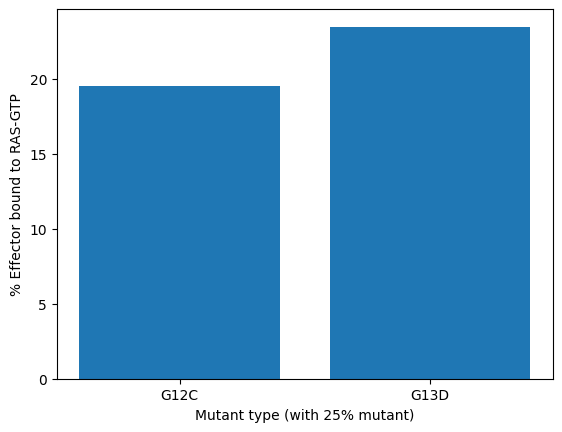

In [5]:
sim1 = ODE_Simulation(RAS_model, WT, G12C, state_parameters)
sim2 = ODE_Simulation(RAS_model, WT, G13D, state_parameters)

Results1 = sim1.integrate_model_to_ss(y0)
Results2 = sim2.integrate_model_to_ss(y0)

plt.bar(["G12C", "G13D"], [Results1["per_RAS_GTP_Eff"], Results2["per_RAS_GTP_Eff"]])
plt.ylabel(r"% Effector bound to RAS-GTP")
plt.xlabel(f"Mutant type (with {round(fract_mut*100)}% mutant)")

Or repeat the same analysis, but for all mutants we have data for (see RAS\data\RAS_ODE_model_kinetic_parameters_v2.xlsx and KRAS_Variants). Here you can start to see the power of the class based approach, both in readability and ease of use.

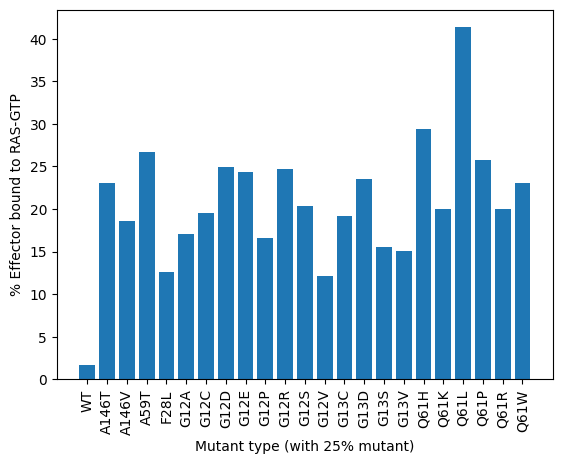

In [6]:
percents = []
labels = []

for mutant in all_mutants: # all_mutants is defined in KRAS_Variant where all the mutants are generated.
    sim = ODE_Simulation(RAS_model, WT, mutant, state_parameters)
    Results = sim.integrate_model_to_ss(y0)
    percents.append(Results["per_RAS_GTP_Eff"])
    labels.append(mutant.name)
    
plt.bar(labels, percents)
plt.ylabel(r"% Effector bound to RAS-GTP")
plt.xlabel(f"Mutant type (with {round(fract_mut*100)}% mutant)")
plt.xticks(rotation=90)
plt.show()

Sensitivity Analysis
--------------------

The most basic sensitivity analysis is simply a parameter sweep - vary a given parameter over some predetermined range and report or plot the results. This can be a quick and simple way to check how a model is affected by changes in a parameter, but it does not take into account variations in other parameters. All of these analyses have "plot_option" as an argument in their respective functions, this can be used to turn off plotting. All of these functions return the results, which could be saved to variables and used for other plotting / data analysis purposes.

First we create a Parameter object. This is a simple class instance that contains some simple information and functions for keeping track of parameter changes.

In [22]:
bounds = [-2,2]             # storing these as a variable to keep all Parameters consistent.
range_type = 'log-uniform'  # storing these as a variable to keep all Parameters consistent.
k_cat_GAP = Parameter("k_cat_GAP", bounds, range_type, type = "kinetic", label="$k_{cat,GAP}$") # Read Parameter documentation in ODE_Simulation.py for more information.

Next we simply run sim.response_line with some custom arguments. Notice how little code is used to run this common simulation.

Running simulations...: 100%|██████████| 50/50 [00:00<00:00, 158.05it/s]


Text(0, 0.5, '% Effector bound to RAS-GTP')

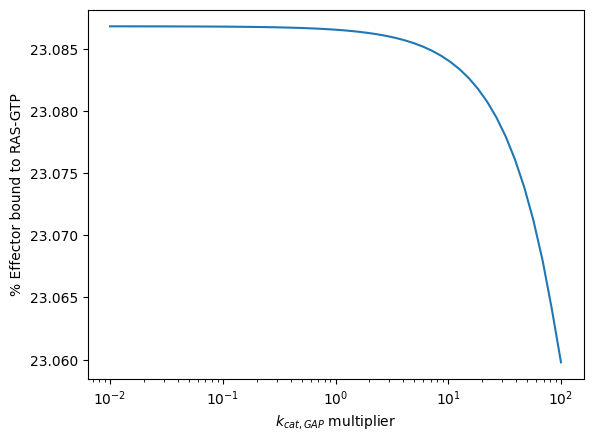

In [8]:
multipliers, responses = sim.response_line(y0, k_cat_GAP, out_option="per_RAS_GTP_Eff", plot_option=True)
plt.ylabel(r"% Effector bound to RAS-GTP")

Usually we want to do this for more than one of our parameters. Lets set them up and create a spider graph, or a graph of all response lines for simple independent parameter sweeps. Notice how we can even vary state parameters by specifying the type in the Parameter initialization.

Running simulations...: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


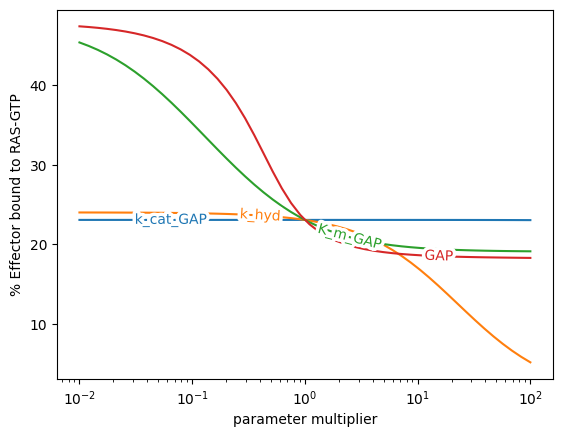

In [14]:
k_hyd = Parameter('k_hyd', bounds, range_type, type='kinetic', label='$k_{hyd}$')
K_m_GAP = Parameter('K_m_GAP', bounds, range_type, type='kinetic', label='$K_{m,GAP}$')
GAP = Parameter('GAP', bounds, range_type, type='state_parameter', label= '[GAP]')

# Put Parameters in list for spider plot.
params_to_modify = [k_cat_GAP, k_hyd, K_m_GAP, GAP]

sim.spider_plot(y0, params_to_modify, out_option="per_RAS_GTP_Eff")
plt.ylabel(r"% Effector bound to RAS-GTP")
plt.show()
#TODO: ensure label-lines uses latex formatting.

Sometimes we want to compare just two parameters varied in tandem (an S2 analysis). We can do that with the built in response_surface method, using two parameters.

Running simulations...: 100%|██████████| 2500/2500 [00:18<00:00, 133.29it/s]


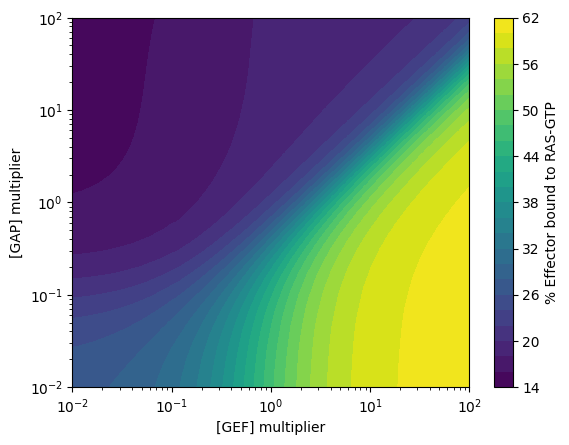

In [21]:
GEF = Parameter('GEF', bounds, range_type, type='state_parameter', label='[GEF]')
out_option = "per_RAS_GTP_Eff" # controls which analysis from Results we desire to be output. #TODO: eliminate this and just save all Results?
p1m, p2m, res = sim.response_surface_2D(y0, GAP, GEF, out_option=out_option, plot_option=True)
cb = plt.colorbar(label=r"% Effector bound to RAS-GTP")